In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from utils.balance_data import Undersampler
from utils.categorical_encoders import CategoricalEncoders

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Leer el dataset
DATASET_PATH = 'data/dataset.csv'
dataset = pd.read_csv(DATASET_PATH, encoding='latin-1' ,sep=';')

In [3]:
# 2. Obtener las columnas binarias y categóricas
categorical = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical.get_binary_categorical_columns()

# 3. Obtener los datos codificados
def get_list_data_encoded():
    encoded_methods = ['LabelEncoder', 'OneHotEncoder', 'OrdinalEncoder', 'FrequencyEncoder', 'BinaryEncoder', 'BackwardDifferenceEncoder']

    i = 0
    list_data_encoded = []
    for encoded_method in encoded_methods:
        data_encoded = categorical.provider(binary_columns, categorical_columns, method=encoded_method)
        list_data_encoded.append((encoded_method, data_encoded))
        print(f'{str(i).zfill(2)}: Encoded method: {encoded_method} - Data shape: {data_encoded.shape}')
        i += 1

    return list_data_encoded

list_data_encoded = get_list_data_encoded()

00: Encoded method: LabelEncoder - Data shape: (8500, 12)
01: Encoded method: OneHotEncoder - Data shape: (8500, 32)
02: Encoded method: OrdinalEncoder - Data shape: (8500, 12)
03: Encoded method: FrequencyEncoder - Data shape: (8500, 12)
04: Encoded method: BinaryEncoder - Data shape: (8500, 25)
05: Encoded method: BackwardDifferenceEncoder - Data shape: (8500, 33)


In [4]:
from sklearn.model_selection import train_test_split

def get_list_data_encoded_split(list_data_encoded, column_target_name, test_size=0.2, random_state=42):
    
    i=0
    list_data_split = []
    for method, data in list_data_encoded:
        X = data.drop(columns=[column_target_name])
        y = data[column_target_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        list_data_split.append((method, X_train, X_test, y_train, y_test))

        print(f'{str(i).zfill(2)}: Method: {method} - Train shape: {X_train.shape}, Test shape: {X_test.shape}')
        i += 1

    
    return list_data_split

# Uso de la función
list_data_encoded_split = get_list_data_encoded_split(list_data_encoded, column_target_name='Target')

_, X_train, X_test, y_train, y_test = list_data_encoded_split[0]
print('\ny_train:', str(y_train.value_counts()))
print('\ny_test:', str(y_test.value_counts()))

00: Method: LabelEncoder - Train shape: (6800, 11), Test shape: (1700, 11)
01: Method: OneHotEncoder - Train shape: (6800, 31), Test shape: (1700, 31)
02: Method: OrdinalEncoder - Train shape: (6800, 11), Test shape: (1700, 11)
03: Method: FrequencyEncoder - Train shape: (6800, 11), Test shape: (1700, 11)
04: Method: BinaryEncoder - Train shape: (6800, 24), Test shape: (1700, 24)
05: Method: BackwardDifferenceEncoder - Train shape: (6800, 32), Test shape: (1700, 32)

y_train: Target
0    6500
1     300
Name: count, dtype: int64

y_test: Target
0    1637
1      63
Name: count, dtype: int64


In [5]:
# 4. Aplicar balanceo de clases a cada list_data_encoded
undersampler = Undersampler()

def get_list_data_encoded_balanced(list_data_encoded_split):
    undersampler_methods = ['random', 'nearmiss', 'tomek', 'centroids', 'enn', 'allknn']
    
    i=0
    list_data_encoded_balanced = []
    for encoded_method, X_train, X_test, y_train, y_test in list_data_encoded_split:
        for undersampler_method in undersampler_methods:
            X_train_balanced, y_train_balanced = undersampler.provider(method=undersampler_method, X=X_train, y=y_train)
            
            list_data_encoded_balanced.append((encoded_method, 
                                               undersampler_method, 
                                               X_train_balanced, 
                                               X_test,
                                               y_train_balanced,
                                               y_test
                                               ))
            print(f'{str(i).zfill(2)}: Encoded method: {encoded_method} - Undersampler method: {undersampler_method} - Train shape: {X_train_balanced.shape} - Test shape: {X_test.shape}')
            i += 1

    return list_data_encoded_balanced

# Aplicar el balanceo a los datos de entrenamiento
list_data_encoded_split_balanced = get_list_data_encoded_balanced(list_data_encoded_split)

_, _, X_train, X_test, y_train, y_test = list_data_encoded_split_balanced[0]
print('\ny_train:', str(y_train.value_counts()))
print('\ny_test:', str(y_test.value_counts()))

00: Encoded method: LabelEncoder - Undersampler method: random - Train shape: (600, 11) - Test shape: (1700, 11)
01: Encoded method: LabelEncoder - Undersampler method: nearmiss - Train shape: (600, 11) - Test shape: (1700, 11)
02: Encoded method: LabelEncoder - Undersampler method: tomek - Train shape: (6773, 11) - Test shape: (1700, 11)
03: Encoded method: LabelEncoder - Undersampler method: centroids - Train shape: (600, 11) - Test shape: (1700, 11)
04: Encoded method: LabelEncoder - Undersampler method: enn - Train shape: (6231, 11) - Test shape: (1700, 11)
05: Encoded method: LabelEncoder - Undersampler method: allknn - Train shape: (6403, 11) - Test shape: (1700, 11)
06: Encoded method: OneHotEncoder - Undersampler method: random - Train shape: (600, 31) - Test shape: (1700, 31)
07: Encoded method: OneHotEncoder - Undersampler method: nearmiss - Train shape: (600, 31) - Test shape: (1700, 31)
08: Encoded method: OneHotEncoder - Undersampler method: tomek - Train shape: (6778, 31)

In [6]:
from sklearn.metrics import roc_auc_score
from utils.base_models import BaseModels

# Inicializar BaseModels y definir los nombres de los modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'decision_tree', 'random_forest',
               'gradient_boosting', 'svm', 'knn', 'naive_bayes', 'mlp',
               'lgbm', 'catboost', 'xgboost']

i = 0
all_results = []
for encoded_method, oversampler_method, X_train, X_test, y_train, y_test in list_data_encoded_split_balanced:
    results = []
    for name in name_models:
        model = base_models.provider(name)
        model.fit(X_train, y_train)
        
        predict_train = model.predict_proba(X_train)[:, 1]
        predict_test = model.predict_proba(X_test)[:, 1]

        train_auc = roc_auc_score(y_train, predict_train)
        test_auc = roc_auc_score(y_test, predict_test)

        results.append((name, train_auc, test_auc))

        print(f"{str(i).zfill(2)}: Encoded Method: {encoded_method} - Oversampler Method: {oversampler_method} - AUC on training data with {name}: {train_auc:.3f}")
        print(f"AUC on testing data with {name}: {test_auc:.3f}")
        i += 1

    # Ordenar los resultados por test_auc de mayor a menor
    results.sort(key=lambda x: x[2], reverse=True)

    # Desempaquetar los resultados ordenados y almacenar con el método de codificación y balanceo
    sorted_names, train_aucs, test_aucs = zip(*results)
    all_results.append((encoded_method, oversampler_method, sorted_names, train_aucs, test_aucs))


00: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with logistic_regression: 0.709
AUC on testing data with logistic_regression: 0.676
01: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with decision_tree: 0.995
AUC on testing data with decision_tree: 0.597
02: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with random_forest: 0.994
AUC on testing data with random_forest: 0.680
03: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with gradient_boosting: 0.886
AUC on testing data with gradient_boosting: 0.733
04: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with svm: 0.740
AUC on testing data with svm: 0.701
05: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on training data with knn: 0.809
AUC on testing data with knn: 0.637
06: Encoded Method: LabelEncoder - Oversampler Method: random - AUC on trainin

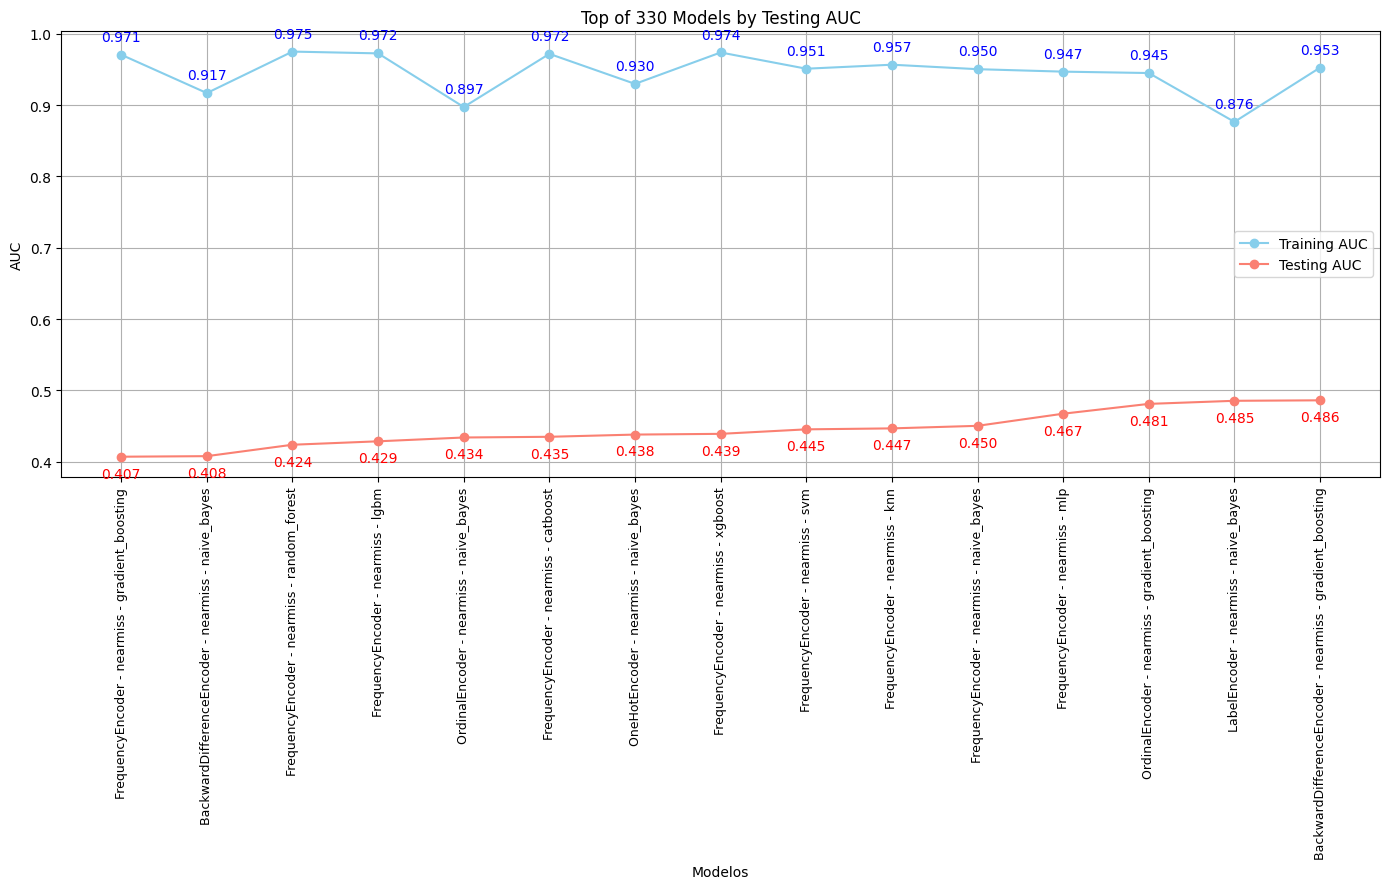

In [9]:
import matplotlib.pyplot as plt

# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_method, oversampler_method, sorted_names, train_aucs, test_aucs in all_results:
    for name, train_auc, test_auc in zip(sorted_names, train_aucs, test_aucs):
        full_model_name = f"{encoded_method} - {oversampler_method} - {name}"
        consolidated_results.append((full_model_name, train_auc, test_auc))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top
consolidated_results.sort(key=lambda x: x[2], reverse=False)
top_results = consolidated_results[:15]

# Desempaquetar los resultados del top
top_names, top_train_aucs, top_10_test_aucs = zip(*top_results)

plt.figure(figsize=(14, 9))

# Gráfico de líneas para el top
plt.plot(top_names, top_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top of 330 Models by Testing AUC')
plt.xticks(rotation=90, fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


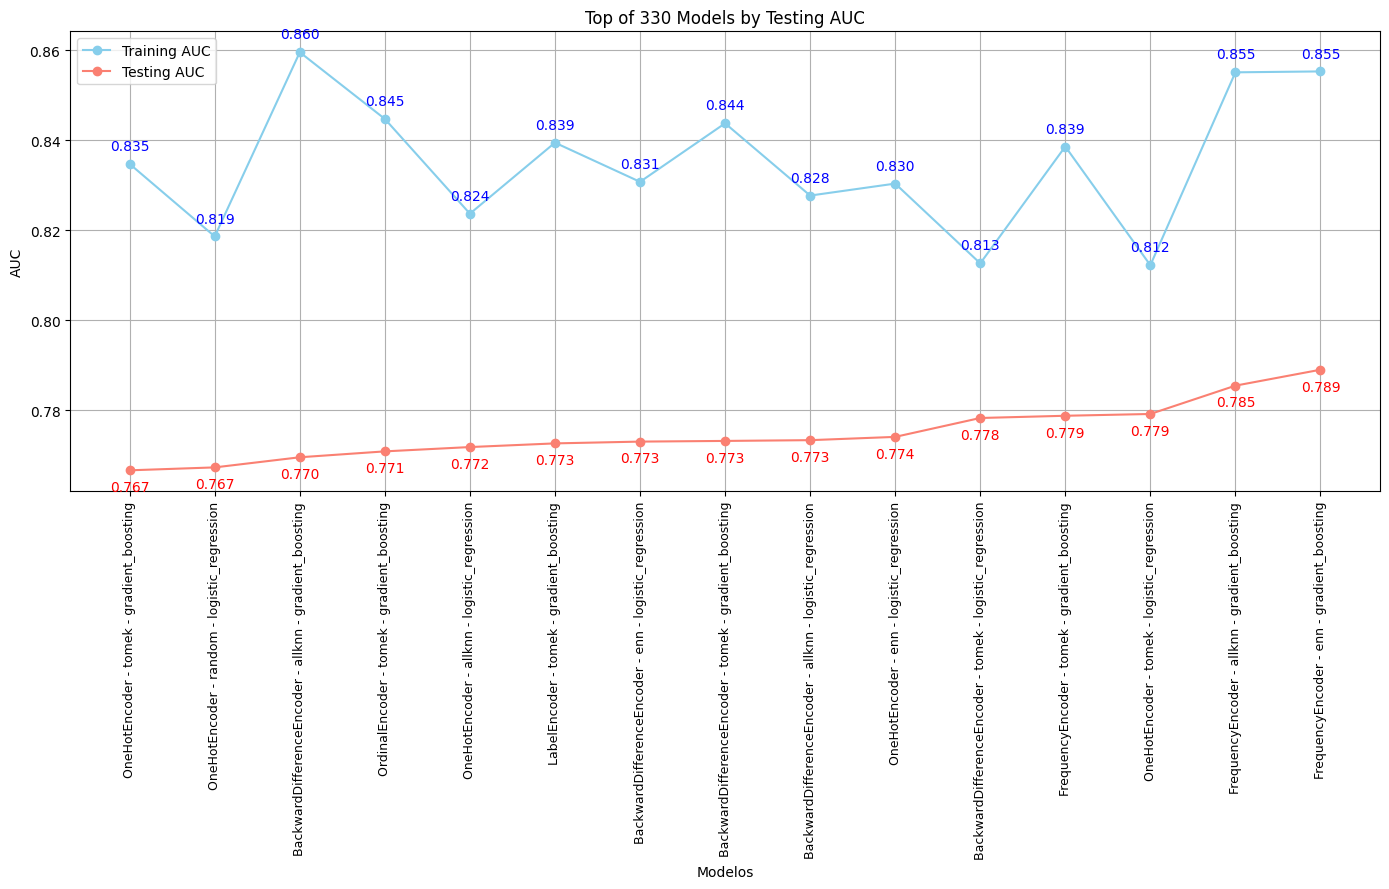

In [10]:
import matplotlib.pyplot as plt

# Consolidar todos los resultados en una lista
consolidated_results = []
for encoded_method, oversampler_method, sorted_names, train_aucs, test_aucs in all_results:
    for name, train_auc, test_auc in zip(sorted_names, train_aucs, test_aucs):
        full_model_name = f"{encoded_method} - {oversampler_method} - {name}"
        consolidated_results.append((full_model_name, train_auc, test_auc))

# Ordenar los resultados por test_auc de mayor a menor y seleccionar el top
consolidated_results.sort(key=lambda x: x[2], reverse=False)
top_results = consolidated_results[-15:]

# Desempaquetar los resultados del top
top_names, top_train_aucs, top_10_test_aucs = zip(*top_results)

plt.figure(figsize=(14, 9))

# Gráfico de líneas para el top
plt.plot(top_names, top_train_aucs, label='Training AUC', marker='o', color='skyblue')
plt.plot(top_names, top_10_test_aucs, label='Testing AUC', marker='o', color='salmon')

# Añadir los valores a los puntos
for i, txt in enumerate(top_train_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_train_aucs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
for i, txt in enumerate(top_10_test_aucs):
    plt.annotate(f'{txt:.3f}', (top_names[i], top_10_test_aucs[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

plt.xlabel('Modelos')
plt.ylabel('AUC')
plt.title('Top of 330 Models by Testing AUC')
plt.xticks(rotation=90, fontsize=9)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
